In [1]:
## quick check that we're ok throwing out a few variables that don't seem to significantly influence cancellation probability.

In [1]:
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

%matplotlib notebook
%timeit

#show up to 100 columns and rows.
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

In [2]:
orig_data_file = "theorem_model_variables_test.pkl"
x_data_file = "theorem_reduced_finalmodel.pkl"
y_data_file = "cancelled.pkl"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(orig_data_file, 'rb') as pickle_file:
    orig_data = pickle.load(pickle_file, encoding='latin1') 

with open(x_data_file, 'rb') as pickle_file:
    reduced_data = pickle.load(pickle_file, encoding='latin1') 
    
with open(y_data_file, 'rb') as pickle_file:
    y = pickle.load(pickle_file, encoding='latin1') 

In [3]:
reduced_data.head()

,BoolPriorProsperLoanee,DolLoanAmountRequested,PctBankcardUtil,StrEmploymentStatus_Employed,StrEmploymentStatus_Full-time,StrEmploymentStatus_Other,StrEmploymentStatus_Self-employed,DolMonthlyDebt,DolMonthlyIncome,BorrowerRate,NumRealEstateTrades,StrOccupation_Accountant/CPA,StrOccupation_Administrative Assistant,StrOccupation_Analyst,StrOccupation_Architect,StrOccupation_Attorney,StrOccupation_Biologist,StrOccupation_Bus Driver,StrOccupation_Car Dealer,StrOccupation_Chemist,StrOccupation_Civil Service,StrOccupation_Clergy,StrOccupation_Clerical,StrOccupation_Computer Programmer,StrOccupation_Construction,StrOccupation_Dentist,StrOccupation_Doctor,StrOccupation_Engineer - Chemical,StrOccupation_Engineer - Electrical,StrOccupation_Engineer - Mechanical,StrOccupation_Executive,StrOccupation_Fireman,StrOccupation_Flight Attendant,StrOccupation_Food Service,StrOccupation_Food Service Management,StrOccupation_Homemaker,StrOccupation_Investor,StrOccupation_Judge,StrOccupation_Laborer,StrOccupation_Landscaping,StrOccupation_Medical Technician,StrOccupation_Military Enlisted,StrOccupation_Military Officer,StrOccupation_Nurse (LPN),StrOccupation_Nurse (RN),StrOccupation_Nurse's Aide,StrOccupation_Other,StrOccupation_Pharmacist,StrOccupation_Pilot - Private/Commercial,StrOccupation_Police Officer/Correction Officer,StrOccupation_Postal Service,StrOccupation_Principal,StrOccupation_Professional,StrOccupation_Professor,StrOccupation_Psychologist,StrOccupation_Realtor,StrOccupation_Religious,StrOccupation_Retail Management,StrOccupation_Sales - Commission,StrOccupation_Sales - Retail,StrOccupation_Scientist,StrOccupation_Skilled Labor,StrOccupation_Social Worker,StrOccupation_Student - College Freshman,StrOccupation_Student - College Graduate Student,StrOccupation_Student - College Junior,StrOccupation_Student - College Senior,StrOccupation_Student - College Sophomore,StrOccupation_Student - Community College,StrOccupation_Student - Technical School,StrOccupation_Teacher,StrOccupation_Teacher's Aide,StrOccupation_Tradesman - Carpenter,StrOccupation_Tradesman - Electrician,StrOccupation_Tradesman - Mechanic,StrOccupation_Tradesman - Plumber,StrOccupation_Truck Driver,StrOccupation_Waiter/Waitress,BoolYoungLoanee,BoolOldLoanee,BoolNonzeroPublicRecordsLast10Years
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,False,15000.0,0.97,1,0,0,0,1242,6000.0000,0.1620,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,False,True,False
981099,False,15000.0,0.48,0,0,1,0,2289,7916.6667,0.1585,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False
1025766,True,4000.0,0.93,1,0,0,0,911,2083.3333,0.2085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False
1003835,False,10000.0,0.26,1,0,0,0,223,3750.0000,0.1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,False
1011335,True,20000.0,0.81,1,0,0,0,1264,9000.0000,0.1440,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True


In [4]:
orig_data['DolTotalBalanceOnPublicRecords']

ListingNumber
973605         0
981099         0
1025766        0
1003835        0
1011335     1249
1010105        0
1029573        0
1014296        0
1009580        0
743482         0
1013984        0
991147         0
996748         0
1020431        0
1036179        0
1036020        0
1038345        0
1042284        0
1004506        0
1004863        0
1008013        0
1026668        0
1012066        0
1061826        0
1055967        0
1041188        0
1042166        0
1061793        0
1018846        0
1037213        0
1037621        0
1022602        0
1041389        0
1022788        0
1046219        0
1065582        0
1067823        0
1065351        0
1071696        0
1112078        0
1072737        0
1051319        0
1048103        0
1066290        0
1055942        0
1028164        0
1072321        0
1052207        0
1112163        0
1052651        0
           ...  
2570966        0
2570981        0
2571011        0
2571032        0
2571743        0
2571128        0
2571134        0


Double-checking that the following variables which appear very weakly correlated with cancellation actually don't improve the model - after all, the effect from BorrowerRate didn't seem big from individual regression, but including that variable improved predictivity.

<IPython.core.display.Javascript object>


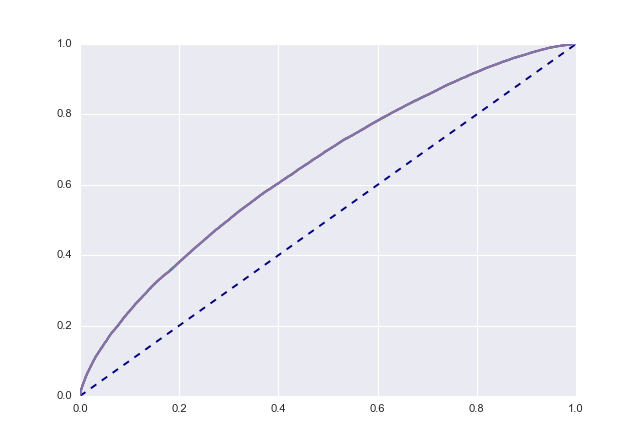

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -2.68672081e-01   2.45184435e-01  -1.43160087e-01   5.24445402e-02
   -8.15560104e-03   7.08053905e-02  -1.52804269e-01  -1.34912223e-01
    4.53340762e-01   7.93987019e-02  -7.78708836e-02  -1.23065093e-01
   -8.86390659e-02  -1.85448856e-01  -3.54056446e-02  -5.26165679e-02
   -1.84974087e-02  -9.33390982e-03  -2.18530247e-02  -2.77425075e-02
   -1.13472162e-01  -1.99326566e-03  -1.02808250e-01  -1.91605395e-01
   -4.04684459e-02   7.64243687e-03  -2.47815575e-02  -2.83527301e-02
   -9.36603553e-02  -9.61638395e-02  -1.32511413e-01  -4.82642101e-02
   -1.07025693e-02  -2.73631620e-03  -3.55173371e-02   2.72243024e-02
    4.80551890e-03  -8.89612657e-03  -2.86635202e-02   3.10004570e-03
   -5.33498107e-02  -7.57116562e-02  -4.96314438e-02  -2.83703218e-02
   -1.44827023e-01  -1.81805652e-03  -3.12439315e-01  -4.41846424e-02
   -2.75833636e-02  -1.13854945e-01  -6.46783852e-02  -3.93970617e-02
   -2.65280338e-01  -6.76904911e-02  -1.83229926e-02   1.53803921e-02
    1.22825536e-02  

In [5]:
variables = [['DolTotalBalanceOnPublicRecords'],['NumMonthsTerm'],['DolAmountDelinquent'],['NumCurrentDelinquencies']]

X_s = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    
    X = pd.concat([reduced_data,orig_data[v]], axis=1)
    standard_scaler = preprocessing.StandardScaler()
    X_s.append(standard_scaler.fit_transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_s[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)

<IPython.core.display.Javascript object>


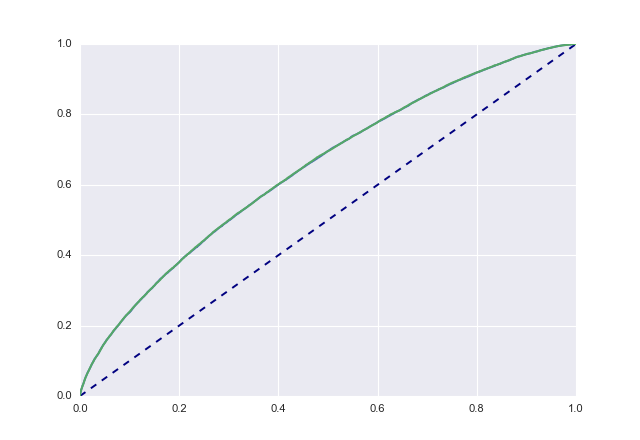

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -2.72537026e-01   2.51202990e-01  -1.47020800e-01   5.07375822e-02
   -8.71945801e-03   7.17501457e-02  -1.51265998e-01  -1.23899513e-01
    4.40138153e-01   6.79449587e-02  -9.04484644e-02  -1.22318391e-01
   -8.94882999e-02  -1.84670732e-01  -3.49498618e-02  -5.18228297e-02
   -1.79952255e-02  -1.07225912e-02  -2.23918108e-02  -2.74004768e-02
   -1.14499078e-01  -1.24555313e-03  -1.04459456e-01  -1.87292586e-01
   -4.01921848e-02   8.26737095e-03  -2.44403431e-02  -2.72407227e-02
   -9.25625638e-02  -9.51468693e-02  -1.32346806e-01  -4.83430916e-02
   -1.13050462e-02  -4.85790299e-04  -3.47169006e-02   2.77446536e-02
    5.91900541e-03  -8.23770200e-03  -2.87657666e-02   3.27352116e-03
   -5.37034610e-02  -7.36518523e-02  -4.94694895e-02  -2.89884719e-02
   -1.44347597e-01   5.80130904e-06  -3.12010633e-01  -4.33994523e-02
   -2.74189196e-02  -1.15207227e-01  -6.55230205e-02  -3.92441143e-02
   -2.67139324e-01  -6.70890155e-02  -1.89025546e-02   1.42576109e-02
    1.28344643e-02  

In [30]:
variables = [[],['DolTotalBalanceOnPublicRecords','NumMonthsTerm','DolAmountDelinquent','NumCurrentDelinquencies']]

X_s = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    
    X = pd.concat([reduced_data,orig_data[v]], axis=1)
    standard_scaler = preprocessing.StandardScaler()
    X_s.append(standard_scaler.fit_transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_s[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)

Let's check out the NumMonthsEmployed/DaysSinceFirstCredit pair

In [33]:
orig_data['DaysSinceFirstCredit'].isnull().sum()

0

<IPython.core.display.Javascript object>


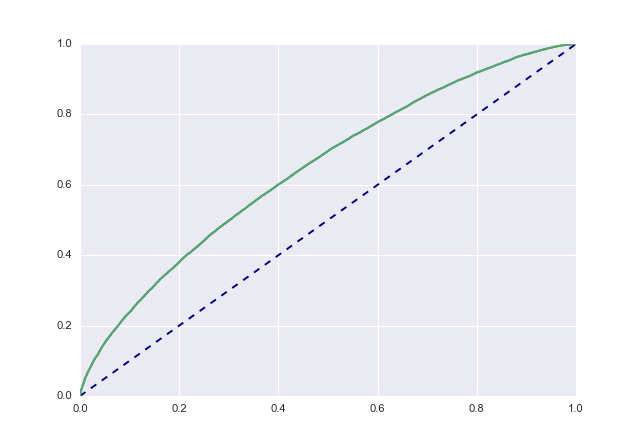

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -2.72537026e-01   2.51202990e-01  -1.47020800e-01   5.07375822e-02
   -8.71945801e-03   7.17501457e-02  -1.51265998e-01  -1.23899513e-01
    4.40138153e-01   6.79449587e-02  -9.04484644e-02  -1.22318391e-01
   -8.94882999e-02  -1.84670732e-01  -3.49498618e-02  -5.18228297e-02
   -1.79952255e-02  -1.07225912e-02  -2.23918108e-02  -2.74004768e-02
   -1.14499078e-01  -1.24555313e-03  -1.04459456e-01  -1.87292586e-01
   -4.01921848e-02   8.26737095e-03  -2.44403431e-02  -2.72407227e-02
   -9.25625638e-02  -9.51468693e-02  -1.32346806e-01  -4.83430916e-02
   -1.13050462e-02  -4.85790299e-04  -3.47169006e-02   2.77446536e-02
    5.91900541e-03  -8.23770200e-03  -2.87657666e-02   3.27352116e-03
   -5.37034610e-02  -7.36518523e-02  -4.94694895e-02  -2.89884719e-02
   -1.44347597e-01   5.80130904e-06  -3.12010633e-01  -4.33994523e-02
   -2.74189196e-02  -1.15207227e-01  -6.55230205e-02  -3.92441143e-02
   -2.67139324e-01  -6.70890155e-02  -1.89025546e-02   1.42576109e-02
    1.28344643e-02  

In [35]:
variables = [[],['DaysSinceFirstCredit']]

X_s = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    
    X = pd.concat([reduced_data,orig_data[v]], axis=1)
    standard_scaler = preprocessing.StandardScaler()
    X_s.append(standard_scaler.fit_transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_s[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)

<IPython.core.display.Javascript object>


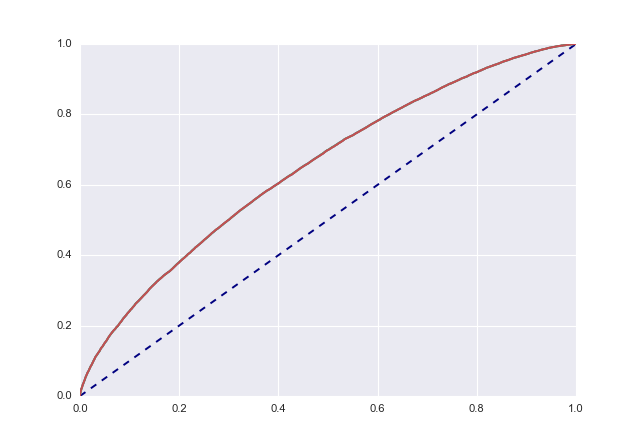

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[[ -2.68664641e-01   2.45275729e-01  -1.43274363e-01   5.23843757e-02
   -8.18813715e-03   7.06626453e-02  -1.52552162e-01  -1.34851593e-01
    4.55987151e-01   7.94582582e-02  -7.80767575e-02  -1.22908124e-01
   -8.87034246e-02  -1.85510048e-01  -3.54262920e-02  -5.23839281e-02
   -1.85055080e-02  -9.38560330e-03  -2.17675509e-02  -2.77565286e-02
   -1.13517680e-01  -2.01019414e-03  -1.02903206e-01  -1.91673740e-01
   -4.04889491e-02   7.89467411e-03  -2.46694769e-02  -2.83666515e-02
   -9.36791956e-02  -9.62080273e-02  -1.32362408e-01  -4.82830178e-02
   -1.07269913e-02  -2.77323080e-03  -3.55102406e-02   2.71818354e-02
    4.75663786e-03  -8.90628054e-03  -2.87280250e-02   3.09641783e-03
   -5.34039881e-02  -7.57190407e-02  -4.96539702e-02  -2.83945136e-02
   -1.44854302e-01  -1.85806890e-03  -3.12517329e-01  -4.42154797e-02
   -2.75877808e-02  -1.13914661e-01  -6.47115449e-02  -3.93836535e-02
   -2.65366943e-01  -6.76939827e-02  -1.83386583e-02   1.54946825e-02
    1.23003131e-02  

In [7]:
variables = [[],['NumTradesOpened6'],['NumOpenTradesDelinqOrPastDue6']]

X_s = []
X_train = []
X_test = []
y_train = []
y_test = []

fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for i,v in enumerate(variables):
    
    X = pd.concat([reduced_data,orig_data[v]], axis=1)
    standard_scaler = preprocessing.StandardScaler()
    X_s.append(standard_scaler.fit_transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_s[i], y, test_size=0.3, random_state=0)
    logm = linear_model.LogisticRegression()
    logm.fit(X_tr,y_tr)
    probs = logm.predict_proba(X_te)
    #print(probs[:20])
    fpr, tpr, thresholds = metrics.roc_curve(y_te,probs[:,1])
    plt.plot(fpr,tpr)
    plt.legend()
    print(logm.coef_)